In [2]:
from time import time
import casadi as ca
import numpy as np
from casadi import sin, cos, pi
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import os
import copy
np.set_printoptions(suppress=True)
%matplotlib inline

## [Documentation](https://web.casadi.org/docs/#document-functionhttps://web.casadi.org/docs/)

NLP solvers distributed with CASADI solves a non-linear program in the following form:


\begin{split}\begin{array}{cc}
\begin{array}{c}
\text{minimize:} \\
x
\end{array}
&
f(x,p)
\\
\begin{array}{c}
\text{subject to:}
\end{array}
&
\begin{array}{rcl}
  x_{\textrm{lb}} \le &  x   & \le x_{\textrm{ub}} \\
  g_{\textrm{lb}} \le &g(x,p)& \le g_{\textrm{ub}}
\end{array}
\end{array}\end{split}

Here $x$ is the decision variable and $p$ is a known parameter.

# Helper functions

In [3]:
def DM2Arr(dm):
    return np.array(dm.full())

In [4]:
def draw_circle(x, y, radius):
    th = np.arange(0,2*np.pi,0.01)
    xunit = radius * np.cos(th) + x
    yunit = radius * np.sin(th) + y
    return xunit, yunit  

In [5]:
def draw(agent_list):
    for i in range(len(agent_list)):
        a = agent_list[i]
        # print(a.X0)
        x = DM2Arr(a.X0)
        u = DM2Arr(a.u0)
        g_state = a.state_target #DM2Arr(a.state_target)
        if(a.id == 1):
            col = 'g'
            plt.scatter(g_state[0], g_state[1], marker='x', color='r')
            plt.scatter(x[0,1:],x[1,1:], marker='.', color='blue', s=1)            
        else:
            col = 'r'
            plt.scatter(x[0,1:],x[1,1:], marker='.', color=col, s=1)

        x_a, y_a = draw_circle(x[0,1], x[1,1], a.radius) 
        plt.plot(x_a, y_a, col, linewidth=1)
        # plt.text(x[0,1], x[1,1]'Vel = %s'%(round(self.agent_vel[0],2)), fontsize=10)


        # plt.annotate(str(a.id), xy=(x[0,1]+0.1, x[1,1]+1.2), size=7)
        
        plt.annotate(str(round(u[0,0])), xy=(x[0,1]+0.1, x[1,1]-0.5), size=10)
        

        plt.plot([(x[0,1]), float(g_state[0])], [x[1,1], float(g_state[1])], linestyle='dotted', c='k')

# MPC Class

In [6]:
class Agent:
    def __init__(self, agent_id, i_state, g_state, N=50):
        self.id = agent_id
        self.radius = 2.0
        self.i_state = np.array(i_state) # start state
        self.g_state = np.array(g_state) # goal state
        self.state_init =  copy.deepcopy(self.i_state)  # initial state
        self.state_target = copy.deepcopy(self.g_state) # target state
        
        # state symbolic variables
        self.x = ca.SX.sym('x')
        self.y = ca.SX.sym('y')
        self.theta = ca.SX.sym('theta')
        self.left_lane_bound = -6.0
        self.right_lane_bound = 6.0
        
        self.states = ca.vertcat(
            self.x,
            self.y,
            self.theta
        )
        self.n_states = self.states.numel()

        # control symbolic variables
        self.v = ca.SX.sym('v')
        self.w = ca.SX.sym('w')
        self.controls = ca.vertcat(
            self.v,
            self.w
        )
        self.n_controls = self.controls.numel()

        self.obstacles = []
        
        self.N = N # planning horizon
        
        # control bounds
        self.v_ub = 20 # velocity upper bound
        self.v_lb = 0 # velocity lower bound
        self.w_ub = 0.5 # angular velocity upper bound
        self.w_lb = -0.5 # angular velocity lower bound
        self.a_ub = 5 # acceleration upper bound
        self.a_lb = -5 # acceleration lower bound
        self.j_ub = 0.1 # angular acceleration upper bound
        self.j_lb = -0.1 # angular acceleration lower bound

        # dt
        self.dt = 0.1
        
        # matrix containing all states over all time steps +1 (each column is a state vector)
        self.X = ca.SX.sym('X', self.n_states, self.N + 1)
        # matrix containing all control actions over all time steps (each column is an action vector)
        self.U = ca.SX.sym('U', self.n_controls, self.N)
        # coloumn vector for storing initial state and target state
        self.P = ca.SX.sym('P', self.n_states + self.n_states)
        # state weights matrix (Q_X, Q_Y, Q_THETA)
        self.Q_x = 20
        self.Q_y = 20
        self.Q_theta = 5
        self.Q = ca.diagcat(self.Q_x, self.Q_y, self.Q_theta)

        # Unicycle model
        self.J = ca.vertcat(
            ca.horzcat(cos(self.theta), 0),
            ca.horzcat(sin(self.theta), 0),
            ca.horzcat( 0, 1)
        )
        # RHS = states + J @ controls * self.dt  # Euler discretization
        self.RHS = self.J @ self.controls
        # maps controls from [v, w].T to [vx, vy, omega].T
        self.f = ca.Function('f', [self.states, self.controls], [self.RHS])

        self.OPT_variables = ca.vertcat(
            self.X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
            self.U.reshape((-1, 1))
        )

        self.u0 = ca.DM.zeros((self.n_controls, self.N))  # initial control
        self.X0 = ca.repmat(self.state_init, 1, self.N+1)  # initial state full
        self.vl = ca.DM(0) # last velocity
        self.wl = ca.DM(0) # last velocity
        
    def get_goal_cost(self):
        # Instead of considering goal cost for every point in the trajectory, we consider only the last point of the trajectory(terminal point) for goal cost calculation

        # cost_fn = 0
        # for k in range(self.N):
        #     st = self.X[:, k]
        #     # con = self.U[:, k]
        #     cost_fn += (st - self.P[self.n_states:]).T @ self.Q @ (st - self.P[self.n_states:])
        # return cost_fn 
        
        st = self.X[:, self.N]
        return (st - self.P[self.n_states:]).T @ self.Q @ (st - self.P[self.n_states:]) 
    
    def next_state_constraints(self):
        self.g = self.X[:, 0] - self.P[:self.n_states]  # self.P[:self.n_states] is the init state
        self.lbg = ca.vertcat(0, 0, 0)
        self.ubg = ca.vertcat(0, 0, 0)
        for k in range(self.N):
            st = self.X[:, k]
            con = self.U[:, k]
            st_next = self.X[:, k+1]

            k1 = self.f(st, con)
            k2 = self.f(st + self.dt/2*k1, con)
            k3 = self.f(st + self.dt/2*k2, con)
            k4 = self.f(st + self.dt * k3, con)
            st_next_RK4 = st + (self.dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

            self.g = ca.vertcat(self.g, st_next - st_next_RK4)

            self.lbg = ca.vertcat(self.lbg, 0, 0, 0)  # 0 <= st_next - st_next_RK4 <= 0
            self.ubg = ca.vertcat(self.ubg, 0, 0, 0)  # 0 <= st_next - st_next_RK4 <= 0
            
    def control_bound_constraints(self):
        self.lbx = ca.vertcat( -ca.inf, -ca.inf, -ca.inf)
        self.ubx = ca.vertcat(  ca.inf, ca.inf, ca.inf)
        for k in range(self.N):
            self.lbx = ca.vertcat(self.lbx, -ca.inf, -ca.inf, -ca.inf)
            self.ubx = ca.vertcat(self.ubx, ca.inf, ca.inf, ca.inf)
        for i in range(self.N):
            self.lbx = ca.vertcat(self.lbx, self.v_lb, self.w_lb)
            self.ubx = ca.vertcat(self.ubx, self.v_ub,self. w_ub)
    
    # Obstacle avoidance constraint
    def obstacle_constraints(self):
        for obs in self.obstacles:
            for i in range(self.N):
                dist = ((self.X[0, i] - (obs[0] + obs[2]*self.dt*i))**2 + (self.X[1, i] - (obs[1] + obs[3]*self.dt*i))**2)**0.5
                self.g = ca.vertcat(self.g, dist)
                self.lbg = ca.vertcat(self.lbg, 5.0)
                self.ubg = ca.vertcat(self.ubg, ca.inf)

    # Lane boundary constraint
    def lane_boundary_constraints(self):        
        for i in range(self.N):
            self.g = ca.vertcat(self.g, self.X[0, i])
            self.lbg = ca.vertcat(self.lbg, self.left_lane_bound + self.radius)
            self.ubg = ca.vertcat(self.ubg, self.right_lane_bound - self.radius)
    
    # Acceleration and angular acceleration bound constraints
    def acceleration_constraints(self):
        for i in range(1, self.N):
            self.g = ca.vertcat(self.g, (self.U[:, i] - self.U[:, i-1])/self.dt)
            self.lbg = ca.vertcat(self.lbg, self.a_lb, self.j_lb)
            self.ubg = ca.vertcat(self.ubg, self.a_ub, self.j_ub)
        self.g = ca.vertcat(self.g, ( DM2Arr(self.u0[:, 0]) - self.U[:, 0])/self.dt)
        self.lbg = ca.vertcat(self.lbg, self.a_lb, self.j_lb)
        self.ubg = ca.vertcat(self.ubg, self.a_ub, self.j_ub)
    
    def angular_acceleration_constraints(self):
        # Angular acceleration bound constraint already defined in 'acceleration_constrains()'
        pass
    
    # Calling function for all the constrains
    def pred_controls(self):
        cost_fn = self.get_goal_cost()
        cost = cost_fn
        self.next_state_constraints()
        self.control_bound_constraints()
        self.lane_boundary_constraints()
        self.acceleration_constraints()
        self.obstacle_constraints()

        nlp_prob = {
            'f': cost,
            'x': self.OPT_variables,
            'g': self.g,
            'p': self.P
        }

        opts = {
            'ipopt': {
                'max_iter': 2000,
                'print_level': 0,
                'acceptable_tol': 1e-8,
                'acceptable_obj_change_tol': 1e-6
            },
            'print_time': 0
        }

        solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

        args = {
            'lbg': self.lbg, #ca.DM.zeros((n_states*(N+1), 1)),  # constraints lower bound
            'ubg': self.ubg, #ca.DM.zeros((n_states*(N+1), 1)),  # constraints upper bound
            'lbx': self.lbx,
            'ubx': self.ubx,
            'p': ca.vertcat(self.state_init, self.state_target ),
            'x0': ca.vertcat(ca.reshape(self.X0, self.n_states*(self.N+1), 1), ca.reshape(self.u0, self.n_controls*self.N, 1))
        }

        t1 = time()
        sol = solver(
            x0=args['x0'],
            lbx=args['lbx'],
            ubx=args['ubx'],
            lbg=args['lbg'],
            ubg=args['ubg'],
            p=args['p']
        )

        self.u0 = ca.reshape(sol['x'][self.n_states * (self.N + 1):], self.n_controls, self.N)
        self.X0 = ca.reshape(sol['x'][: self.n_states * (self.N+1)], self.n_states, self.N+1)

## Static Obstacle Environment

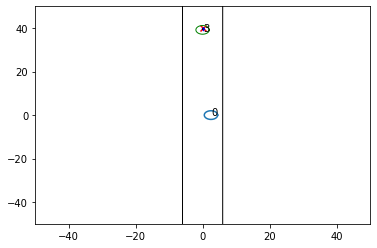

In [7]:
# Plot of ego vehicle trying to reach the goal while avoiding the obstacle
# Here, the red cross denotes the goal point, ego vehicle is denoted by a moving ellipse which is at the starting point initially
# and the static obstacle is denoted by an ellipse which is positioned between the starting point and goal point.  
# We have taken dt as 0.1.

y_lane = np.arange(-1000,1000)
left_lane = -6*np.ones(y_lane.shape)
right_lane = 6*np.ones(y_lane.shape)

a = Agent(1, [0, -40, np.deg2rad(90)],[0,40,np.deg2rad(90)], 30)
# obs = [[2.5,-15, 0, 0], 
#         [-2.5, 15, 0, 0]]
obs = [[2.5, 0, 0, 0]]
a.obstacles = obs
draw_list = [a]
update_y = 0
y_l_lim = -10
y_u_lim = 40
timeout = 20
v_a = []
w_a = []
a_a = []
j_a = []
v_a.append(a.vl.full()[0,0])
w_a.append(a.wl.full()[0,0])
a_a.append(0.0)
j_a.append(0.0)
while ca.norm_2(a.state_init - a.state_target)>=1 and timeout>0:
    
    clear_output(wait=True)
    timeout = timeout - a.dt
    a.pred_controls()
    a.vl = a.u0[0,0]
    a.wl = a.u0[1,0]
    a.state_init = a.X0[:,1]
    draw(draw_list)
    for o in obs:
        obs_x, obs_y = draw_circle(o[0], o[1], 2)
        plt.plot(obs_x, obs_y)
        plt.annotate(str(round((o[2]**2+o[3]**2)**0.5)), xy=(o[0], o[1]), size=10)
    plt.plot(left_lane,y_lane, 'k', linewidth=1)
    plt.plot(right_lane, y_lane, 'k', linewidth=1)
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plt.show()
    plt.pause(1e-10)

## Dynamic Obstacle Environment

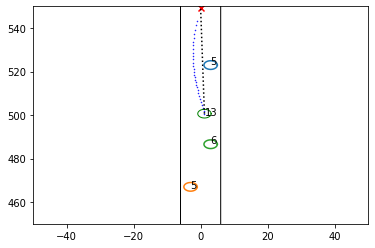

In [8]:
# Plot of ego vehicle trying to reach the goal while avoiding the obstacle
# Here, the red cross denotes the goal point, ego vehicle is denoted by a moving ellipse which is at the starting point initially
# and the static obstacle is denoted by an ellipse which is positioned between the starting point and goal point.  
# We have taken dt as 0.1.

y_lane = np.arange(-1000,1000)
left_lane = -6*np.ones(y_lane.shape)
right_lane = 6*np.ones(y_lane.shape)

a = Agent(1, [0, -40, np.deg2rad(90)],[0,50,np.deg2rad(90)], 30)
a.mode="dynamic"
# obs = [[2.5,-15, 0, 0], 
#         [-2.5, 15, 0, 0]]
obs = [[3.0, -20, 0, 5],
       [-3.0, 10, 0, -5],
       [3.0, 10, 0, 6],
       [-3.0, 40, 0, -6],]
a.obstacles = obs
draw_list = [a]
update_y = 0
y_l_lim = -10
y_u_lim = 40
timeout = 200
v_a = []
w_a = []
a_a = []
j_a = []
v_a.append(a.vl.full()[0,0])
w_a.append(a.wl.full()[0,0])
a_a.append(0.0)
j_a.append(0.0)
ylim_max = 50
while ca.norm_2(a.state_init - a.state_target)>=1 and DM2Arr(a.X0)[1,1]<500:
    a.obstacles = obs
    clear_output(wait=True)
    timeout = timeout - a.dt
    a.pred_controls()
    a.vl = a.u0[0,0]
    a.wl = a.u0[1,0]
    a.state_init = a.X0[:,1]
    draw(draw_list)
    x = DM2Arr(a.X0)
    for o in obs:
        obs_x, obs_y = draw_circle(o[0], o[1], 2)
        plt.plot(obs_x, obs_y)
        o[0] = o[0] + o[2]*a.dt
        o[1] = o[1] + o[3]*a.dt
        if o[1]<x[1,1]-50:
            o[1] = o[1] + 125
        plt.annotate(str(round((o[2]**2+o[3]**2)**0.5)), xy=(o[0], o[1]), size=10)
    a.state_target = [0, x[1,1]+50, np.deg2rad(90)]
    plt.plot(left_lane,y_lane, 'k', linewidth=1)
    plt.plot(right_lane, y_lane, 'k', linewidth=1)
    plt.xlim([-50, 50])
    if ylim_max-x[1,1]<40:
        ylim_max = ylim_max+50
    plt.ylim([ylim_max-100, ylim_max])
    # plt.ylim([-50+x[1,1], 50+x[1,1]])
    plt.show()
    plt.pause(1e-10)